In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import os
from PIL import Image
import torch
from torchvision import transforms
import random
import cv2

In [2]:
class CustomDataset(Dataset):
    """
    A custom dataset class for loading data from a CSV file.

    Args:
        csv_file (str): Path to the CSV file containing image filenames and scores.
        root_dir (str): Root directory containing the image files.
        transform (callable, optional): Optional transform to be applied to the images.

    Attributes:
        data (pandas.DataFrame): DataFrame containing the data loaded from the CSV file.
        root_dir (str): Root directory containing the image files.
        transform (callable, optional): Optional transform to be applied to the images.
    """
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, str(self.data.iloc[idx, 0]))
        image = Image.open(img_name)
        scores = np.hstack(self.data.iloc[idx, 1:].values).astype(np.float32)
        scores = torch.from_numpy(scores)
        if self.transform:
            image = self.transform(image)
        return image, scores
    
    def feature_engineering(self):
        # Perform feature engineering if necessary
        # Example: Create new features based on existing ones
        # data['new_feature'] = data['feature1'] + data['feature2']
        return self.data

In [3]:
csv_file='../data/car_imgs_4000.csv'
root_dir='../data/imgs'

In [4]:
# Load dataset and split into train/validation/test
dataset = CustomDataset(csv_file=csv_file,
                        root_dir=root_dir,
                        transform=None)

<h2>Data description</h2>

In [5]:
def explore_data(dataset):
    # Display basic statistics
    print("Basic statistics of the dataset:")
    return dataset.data.describe()

In [6]:
explore_data(dataset)

Basic statistics of the dataset:


perspective_score_hood  perspective_score_backdoor_left
count             4000.000000                      4000.000000
mean                 0.303032                         0.313368
std                  0.382582                         0.372334
min                  0.000000                         0.000000
25%                  0.000000                         0.000000
50%                  0.000000                         0.000000
75%                  0.771014                         0.686797
max                  0.922428                         0.939541

<b> count: </b> Indicates the number of non-null values in each column. In this case, both columns have 4000 non-null values, suggesting there are no missing values.<br> 
<b>mean:  </b> Represents the average value of each column. For perspective_score_hood, the mean is approximately 0.303, and for perspective_score_backdoor_left, it's approximately 0.313. This indicates that, on average, the scores for both perspectives are relatively low.<br> 
<b>std: </b>  Denotes the standard deviation, which measures the dispersion or spread of the values around the mean. A higher standard deviation indicates greater variability in the data. In this case, both columns have relatively similar standard deviations, around 0.38, suggesting moderate variability in the scores.<br> 
<b> 25%, 50%, 75%: </b>  These values represent the quartiles of the data distribution. For example, the 25th percentile (first quartile) is the value below which 25% of the observations fall. The median (50th percentile) represents the middle value of the dataset. The 75th percentile (third quartile) is the value below which 75% of the observations fall. These quartiles provide insights into the distribution of scores within each column.<br> 
<b>min:</b> Represents the minimum value observed in each column. Both columns have a minimum value of 0, indicating that there are observations with a score of 0 for both perspectives.<br> 
<b>max:  </b> Denotes the maximum value observed in each column. For perspective_score_hood, the maximum score is approximately 0.922, and for perspective_score_backdoor_left, it's approximately 0.940. This indicates the highest score observed for each perspective.<br> 

<h2>Labels distributions</h2>

In [7]:
def count_images_per_perspective_data(dataset):
    """
    Count the number of images per perspective data category.

    Args:
        dataset: The dataset containing perspective score data.

    Returns:
        dict: A dictionary containing counts of images for each perspective category.
    """
    count_images = {
        'hood': 0,
        'backdoor_left': 0,
        'both': 0,
        'else': 0,
    }

    mean_score_hood = dataset.data['perspective_score_hood'].mean()
    mean_score_backdoor_left = dataset.data['perspective_score_backdoor_left'].mean()
        
    for index, row in dataset.data.iterrows():
        score_hood = row['perspective_score_hood']
        score_backdoor_left = row['perspective_score_backdoor_left']

        if score_hood == 0.0 and score_backdoor_left == 0.0: 
            count_images['else'] += 1

        elif score_hood > mean_score_hood and score_backdoor_left > mean_score_backdoor_left:
            count_images['both'] += 1

        elif score_hood > mean_score_hood:
            count_images['hood'] += 1

        else:
            count_images['backdoor_left'] += 1
    return count_images

[Text(0, 0, '981'), Text(0, 0, '1571'), Text(0, 0, '503'), Text(0, 0, '945')]

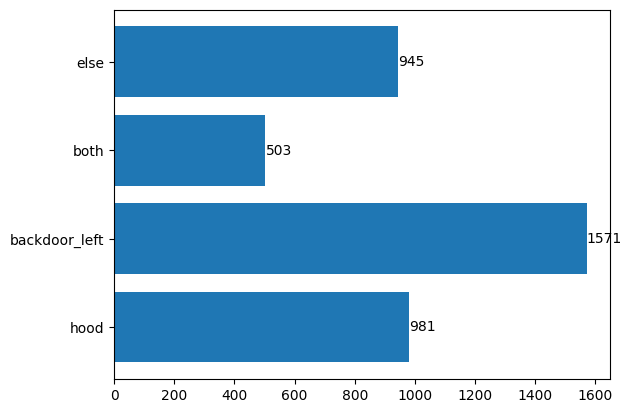

In [8]:
counts = count_images_per_perspective_data(dataset)

fig, ax = plt.subplots()
bars = ax.barh(*zip(*counts.items()))

ax.bar_label(bars)

<h2>Correlation coefficient between perspective_score_hood and perspective_score_backdoor_left</h2>

In [9]:
def visualize_correlation(dataset):
    """
    Visualize correlations between variables in the dataset.

    Args:
        dataset: The dataset containing variables to visualize correlations.

    Returns:
        pandas.DataFrame: A DataFrame representing the correlation matrix.
    """
    # Visualize correlations between variables
    correlation_matrix = dataset.data.corr()
    return correlation_matrix

In [10]:
visualize_correlation(dataset)

/var/folders/22/fdh18d953zx225kxqj3nhy6sqfmh0s/T/ipykernel_79422/3466930176.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = dataset.data.corr()


perspective_score_hood  \
perspective_score_hood                         1.000000   
perspective_score_backdoor_left               -0.212013   

                                 perspective_score_backdoor_left  
perspective_score_hood                                 -0.212013  
perspective_score_backdoor_left                         1.000000

This value indicates the strength and direction of the linear relationship between the <b>perspective_score_hood</b> and <b>perspective_score_backdoor_left</b> columns. In this case, the correlation coefficient is negative (-0.212013), which means that as the score for the hood perspective increases, the score for the backdoor left perspective tends to decrease, and vice versa. However, the correlation coefficient is relatively weak (close to zero), suggesting a weak negative correlation between these two variables.

<h2>Display random images</h2>

In [11]:
def select_and_display_random_images(dataset, random_indices, num_images, is_tensor=False):
    """
    Select and display random images from the dataset.

    Args:
        dataset: The dataset containing images.
        random_indices (list): List of indices for selecting random images.
        num_images (int): Number of images to display.
        is_tensor (bool, optional): Whether the images in the dataset are tensors. Defaults to False.
    """
    # Randomly select num_images from the list of selected images
    fig, axes = plt.subplots(num_images//2, 2, figsize=(20, 20))
    fig.tight_layout(pad=7.0) # Or equivalently,  "plt.tight_layout()"
    i = 0
    for oo in range(0,num_images//2):
        for ii in range(0, 2):
            index = random_indices[i]
            image, labels = dataset[index]
            title = 'Labels: Hood: %.2f,Backdoor left %.2f' % (labels[0], labels[1])
            if is_tensor:
                image = image[0]
            axes[oo, ii].imshow(image)
            axes[oo, ii].set_title(title)
            i += 1
    plt.show()

In [12]:
num_images = 6
random_indices = random.sample(range(len(dataset)),num_images)

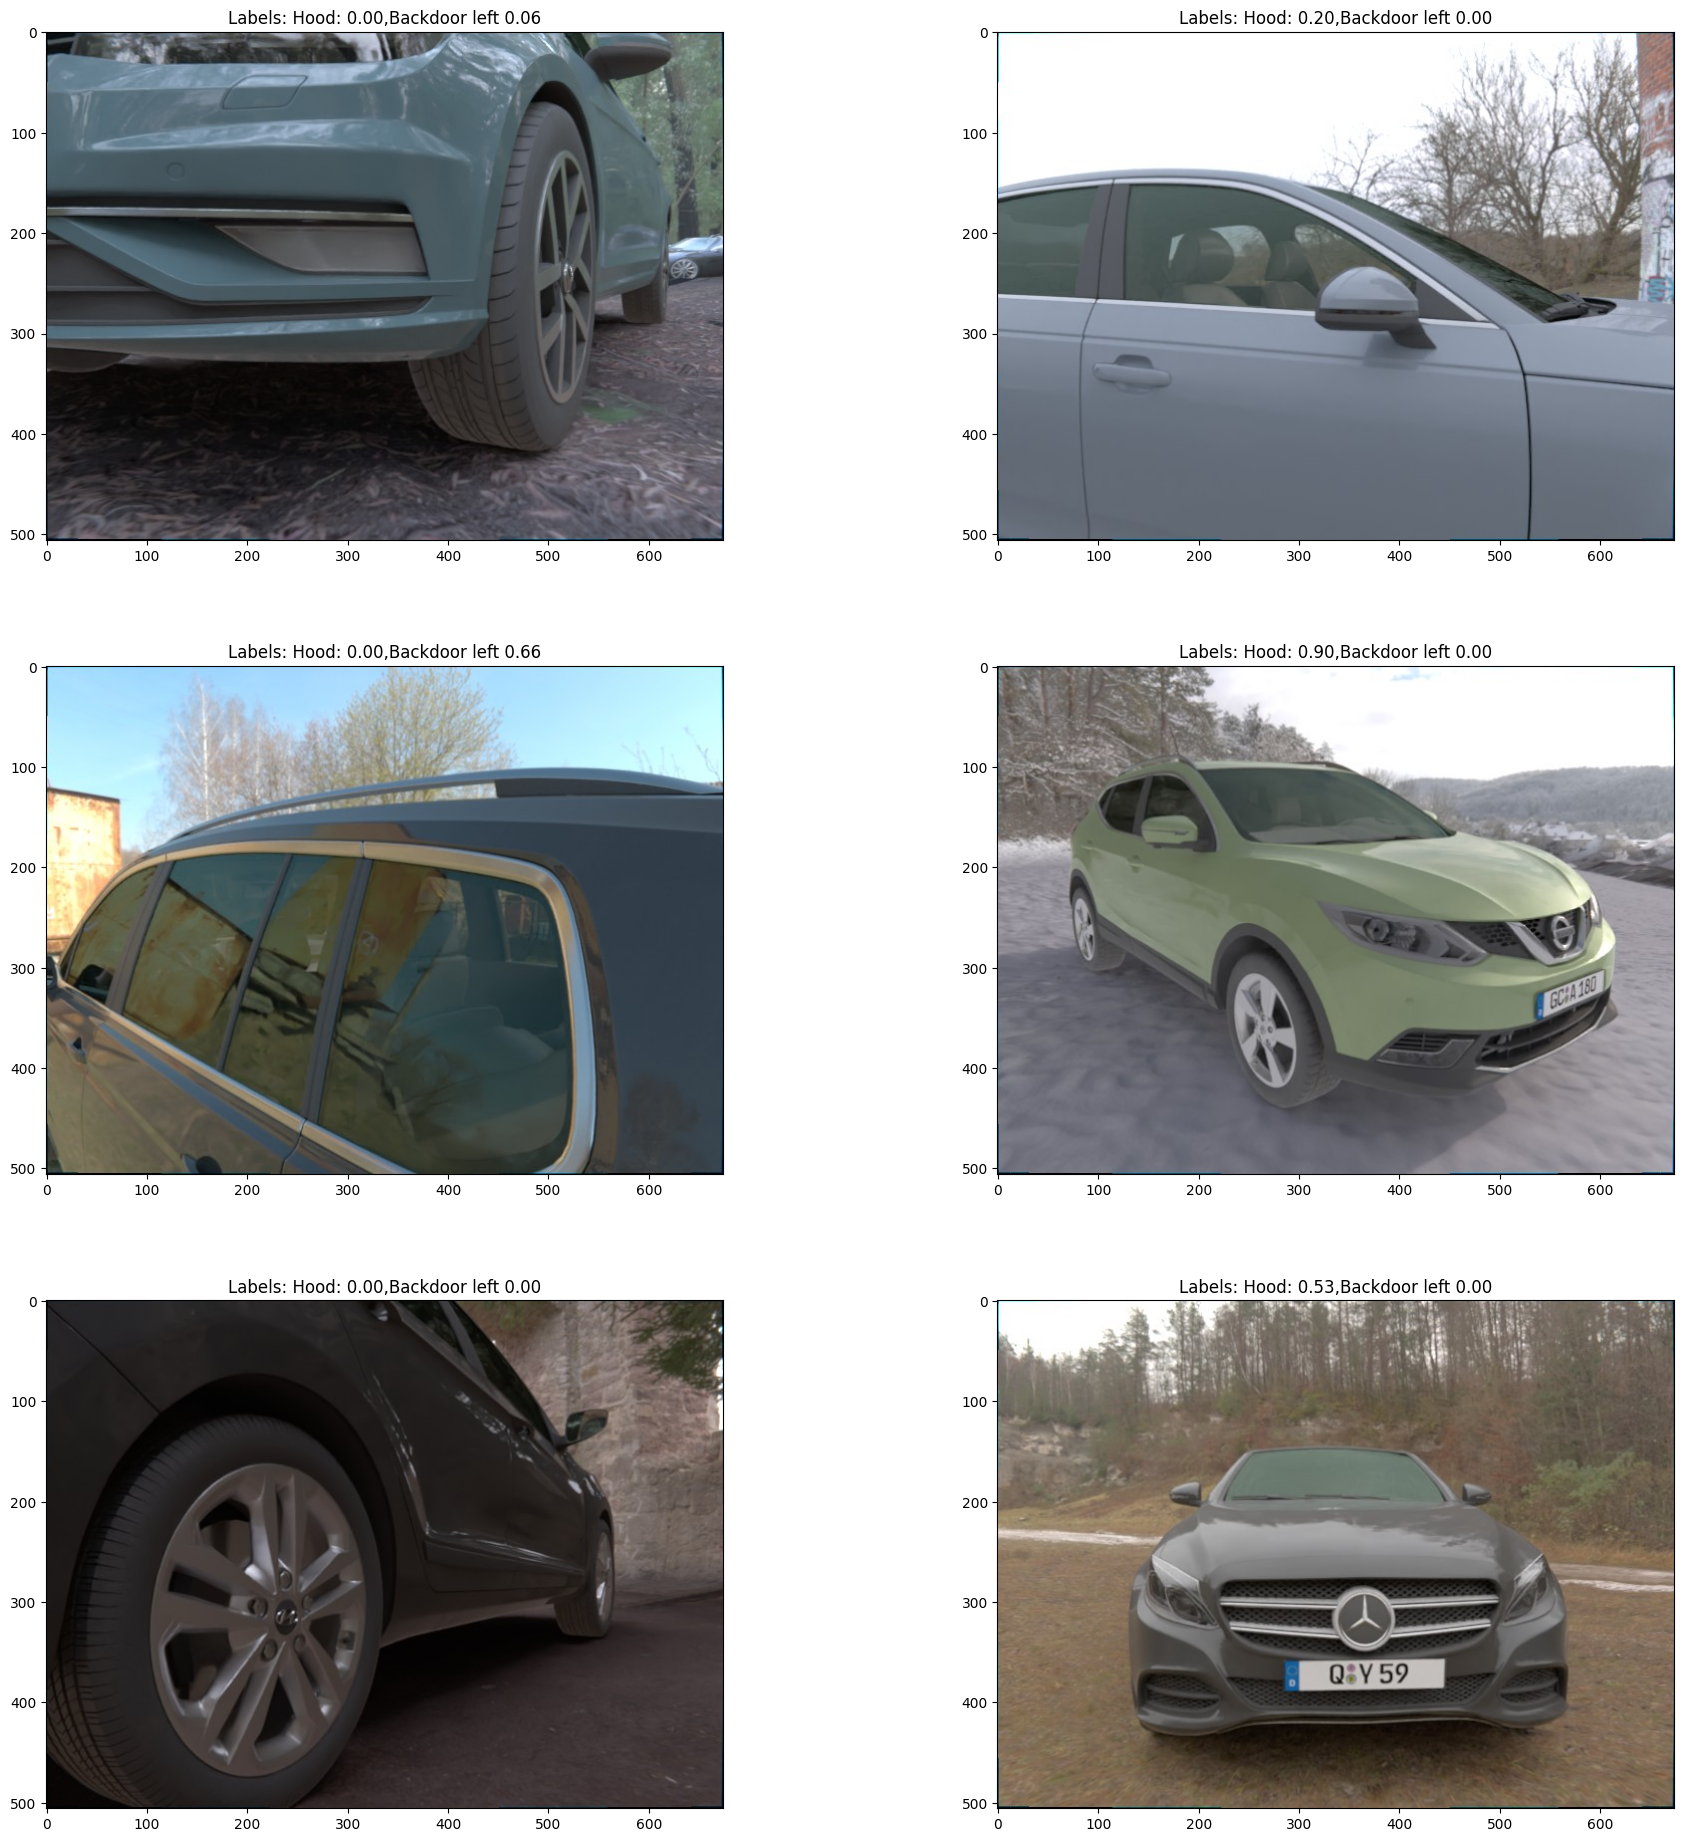

In [13]:
select_and_display_random_images(dataset, random_indices, num_images)

<h2>Data Augmentation Effects</h2>

The aim is to check qualitatively the effects of different data augmentation techniques on images

In [14]:
class ApplyNormalize(object):
    """
    Apply normalization to a tensor.

    Args:
        mean (float or sequence): Mean value for normalization.
        std (float or sequence): Standard deviation for normalization.

    Returns:
        torch.Tensor: Normalized tensor.

    """
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Apply normalization to the input tensor.

        Args:
            tensor (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Normalized tensor.
        """
        return transforms.Normalize((self.mean, ), (self.std, ))(tensor)


    def __repr__(self):
        """
        Return a string representation of the object.

        Returns:
            str: String representation of the object.
        """
        return f"{self.__class__.__name__} (mean={self.mean}, std={self.std})"
    

class AdjustSharpness(object):
    """
    Adjust the sharpness of an image.

    Args:
        sharpness_factor (float, optional): The sharpness factor. 
        If None, a random sharpness factor will be applied.
        p (float, optional): Probability of applying the sharpness adjustment.

    Returns:
        torch.Tensor: Adjusted image tensor.
    """
    def __init__(self,  sharpness_factor=None, p=0.25):
        self.sharpness_factor = sharpness_factor
        self.p = p

    def __call__(self, tensor):
        """
        Apply sharpness adjustment to the input tensor.

        Args:
            tensor (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Adjusted tensor.
        """
        if random.random() < self.p:
            if not self.sharpness_factor:
                sharpness_factor = random.uniform(0.5, 1.5)
            return transforms.functional.adjust_sharpness(tensor,
                                                          self.sharpness_factor)
        else:
            return tensor

    def __repr__(self):
        """
        Return a string representation of the object.

        Returns:
            str: String representation of the object.
        """
        repr_str = (f"{self.__class__.__name__} "
                    + f"(sharpness_factor={self.sharpness_factor})")
        return repr_str
    
    
class AdjustBrightness(object):
    """
    Adjust the brightness of an image.

    Args:
        brightness_factor (float, optional): The brightness factor. 
        If None, a random brightness factor will be applied.
        p (float, optional): Probability of applying the brightness adjustment.

    Returns:
        torch.Tensor: Adjusted image tensor.
    """
    def __init__(self, brightness_factor=None, p=0.25):
        self.brightness_factor = brightness_factor
        self.p = p

    def __call__(self, tensor):
        """
        Apply brightness adjustment to the input tensor.

        Args:
            tensor (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Adjusted tensor.
        """
        if random.random() < self.p:
            brightness_factor = self.brightness_factor
            if not brightness_factor:
                brightness_factor = random.uniform(0.6, 1.4)
            return transforms.functional.adjust_brightness(tensor,
                                                           self.brightness_factor)
        else:
            return tensor

    def __repr__(self):
        """
        Return a string representation of the object.

        Returns:
            str: String representation of the object.
        """
        repr_str = (f"{self.__class__.__name__} "
                    + f"(brightness_factor={self.brightness_factor})")
        return repr_str



In [15]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
])

resized_dataset = CustomDataset(csv_file=csv_file,
                                root_dir=root_dir,
                                transform=transform)

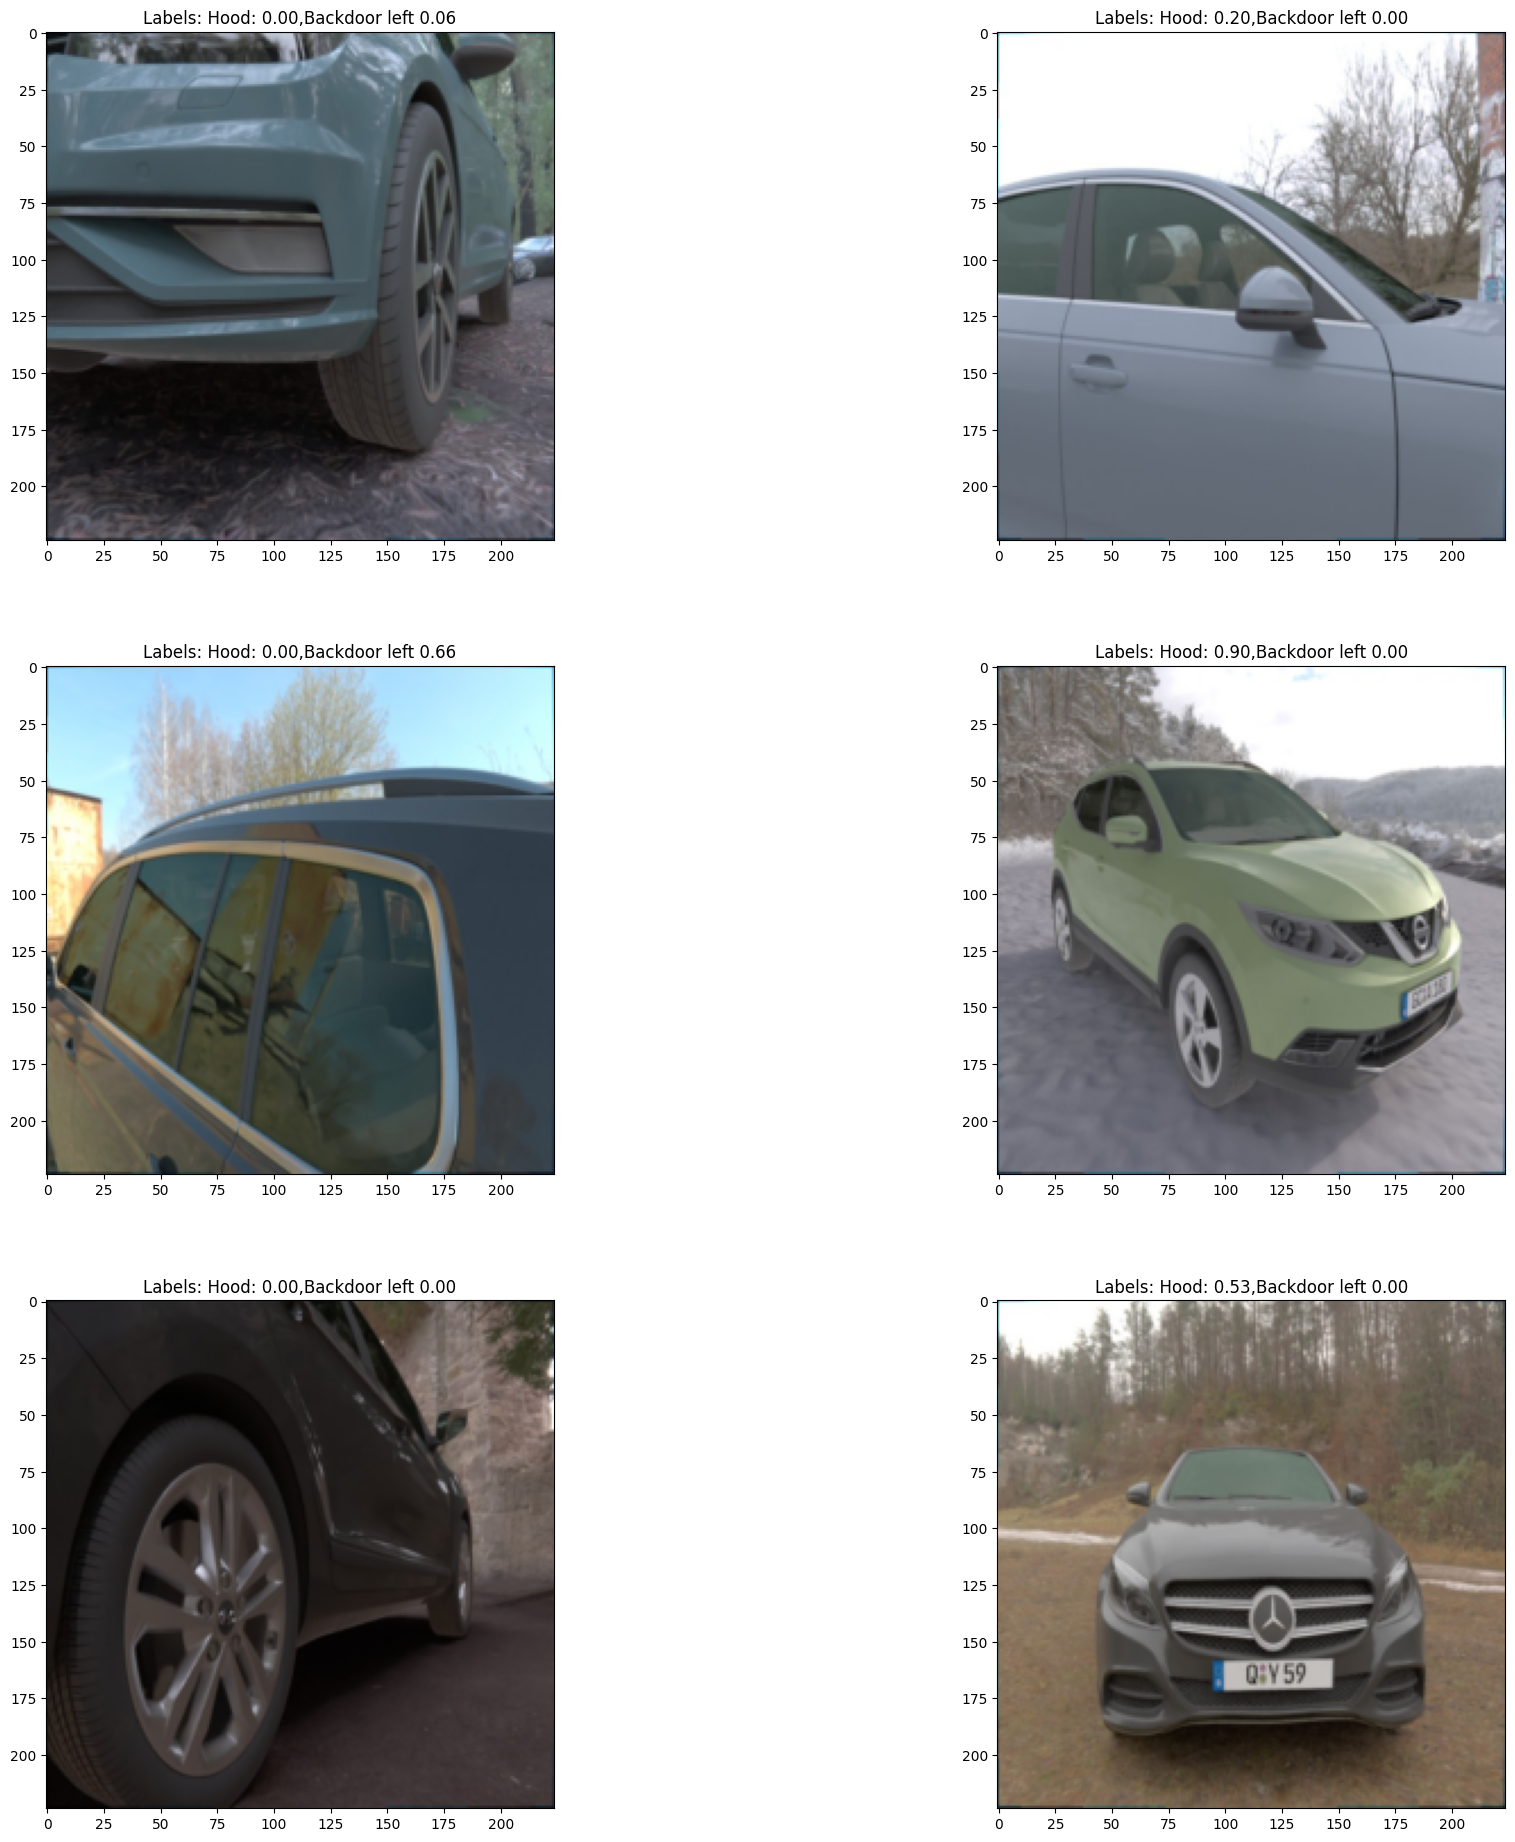

In [16]:
select_and_display_random_images(resized_dataset, random_indices, num_images)

In [17]:
def retrieve_mean_std(dataset):
    mean_sum = 0
    std_sum = 0
    total_pixel = 0

    for img, label in dataset:
        img = transforms.ToTensor()(img)
        mean_sum = mean_sum + torch.sum(img[:, :])
        total_pixel = total_pixel+img.shape[1] * img.shape[2] 

    mean = mean_sum / total_pixel

    for img, label in dataset:
        img = transforms.ToTensor()(img)
        std_sum = std_sum + torch.sum((img[:, :] - mean) ** 2)
        total_pixel = total_pixel + img.shape[1] * img.shape[2]

    std = torch.sqrt(std_sum / total_pixel)
    return mean, std

In [18]:
mean, std = retrieve_mean_std(dataset)

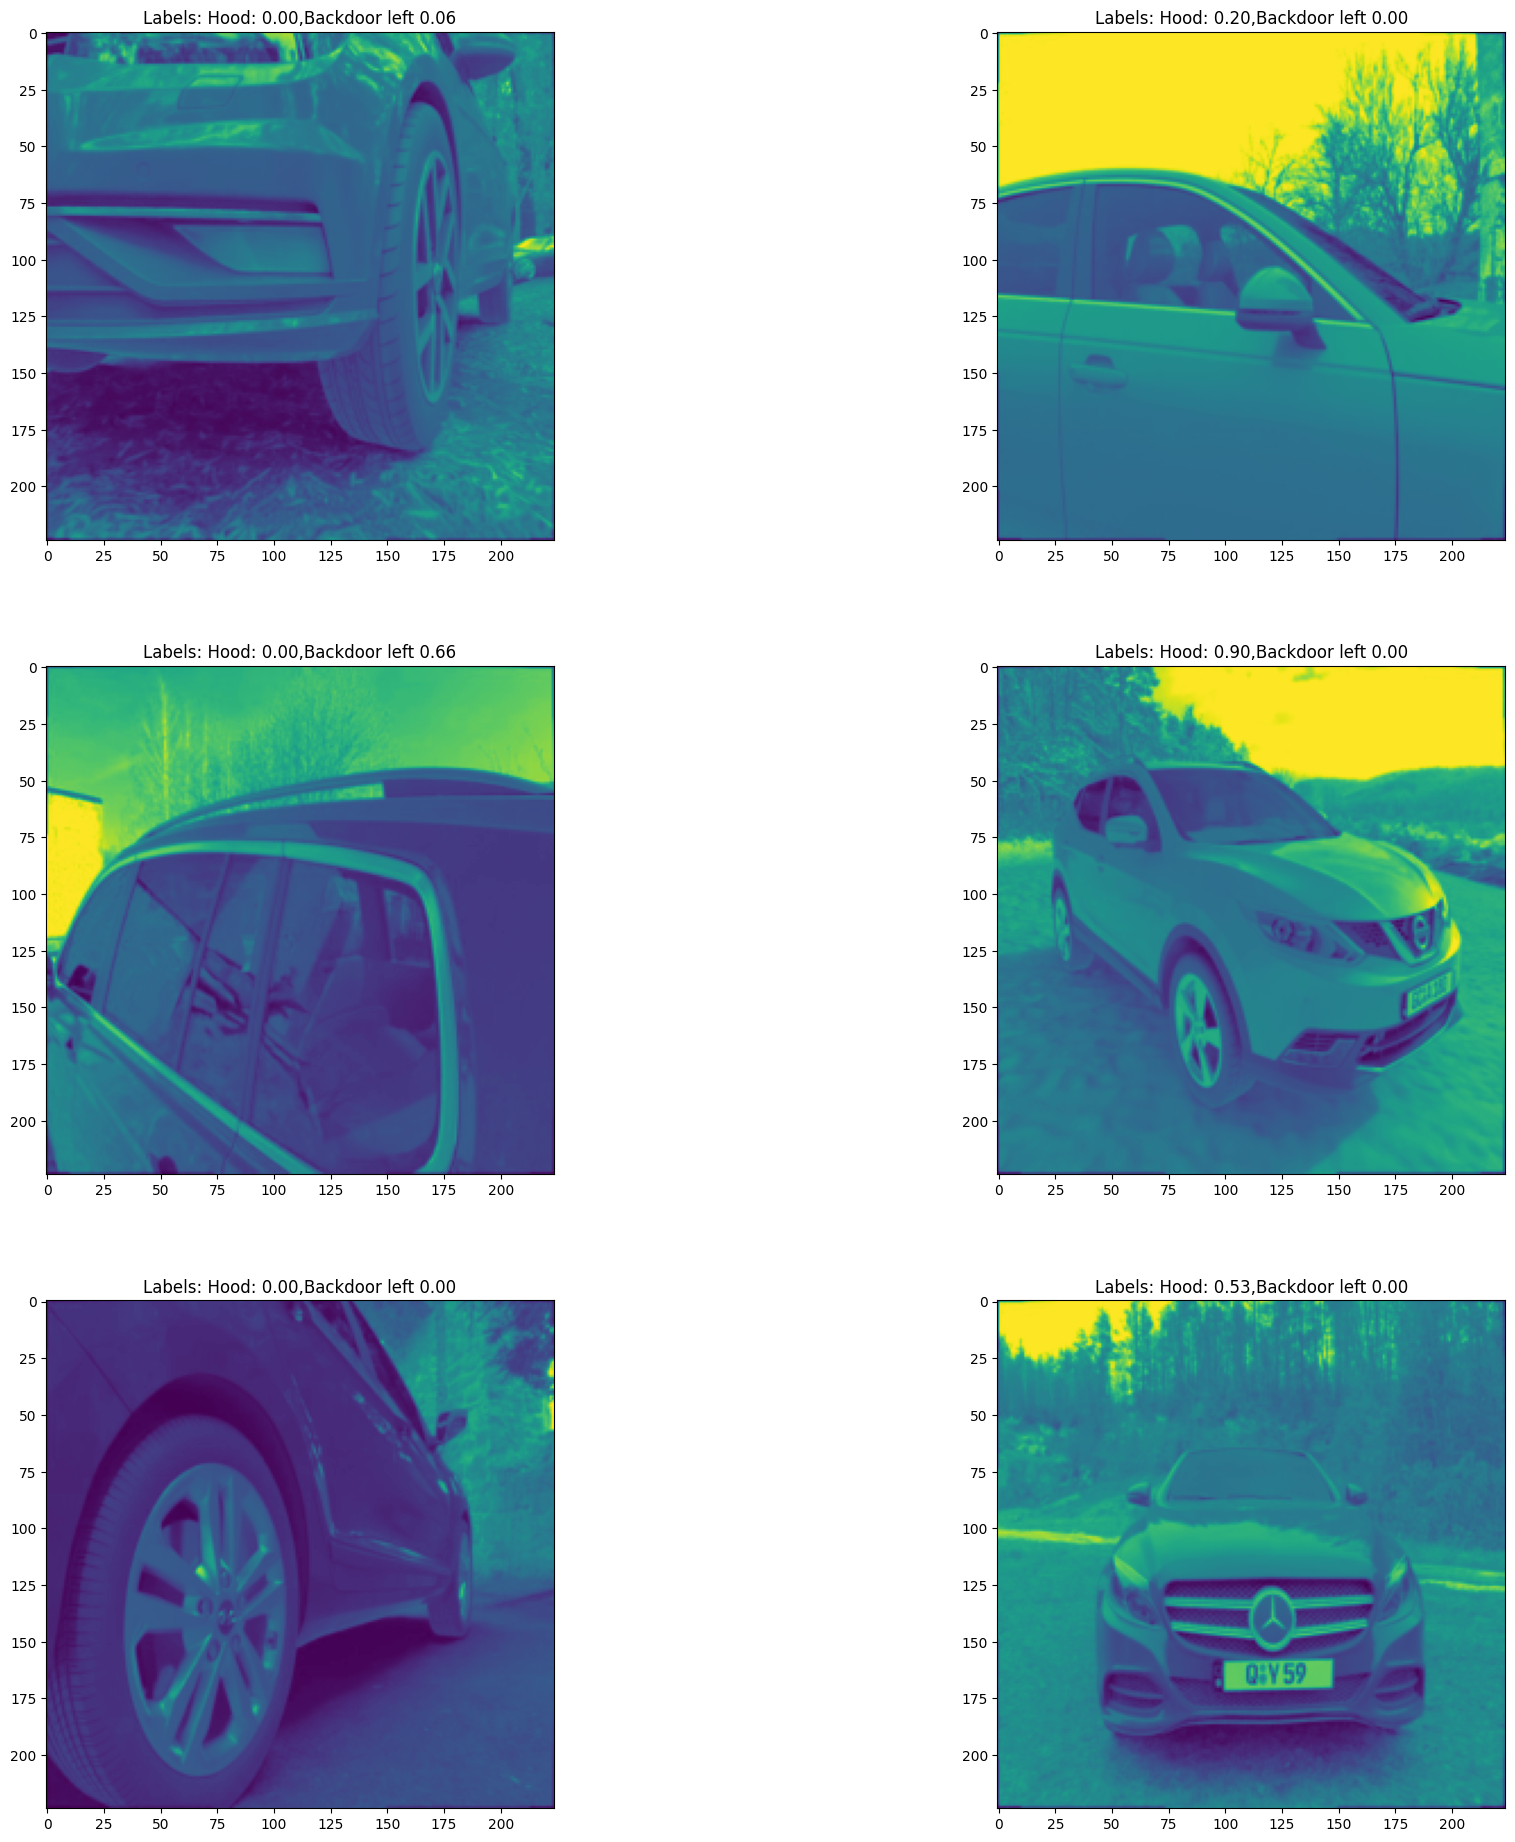

In [19]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    ApplyNormalize(mean=mean,
                  std=std)
])
normalized_dataset = CustomDataset(csv_file=csv_file,
                                   root_dir=root_dir,
                                   transform=transform)
select_and_display_random_images(normalized_dataset, random_indices, num_images, is_tensor=True)

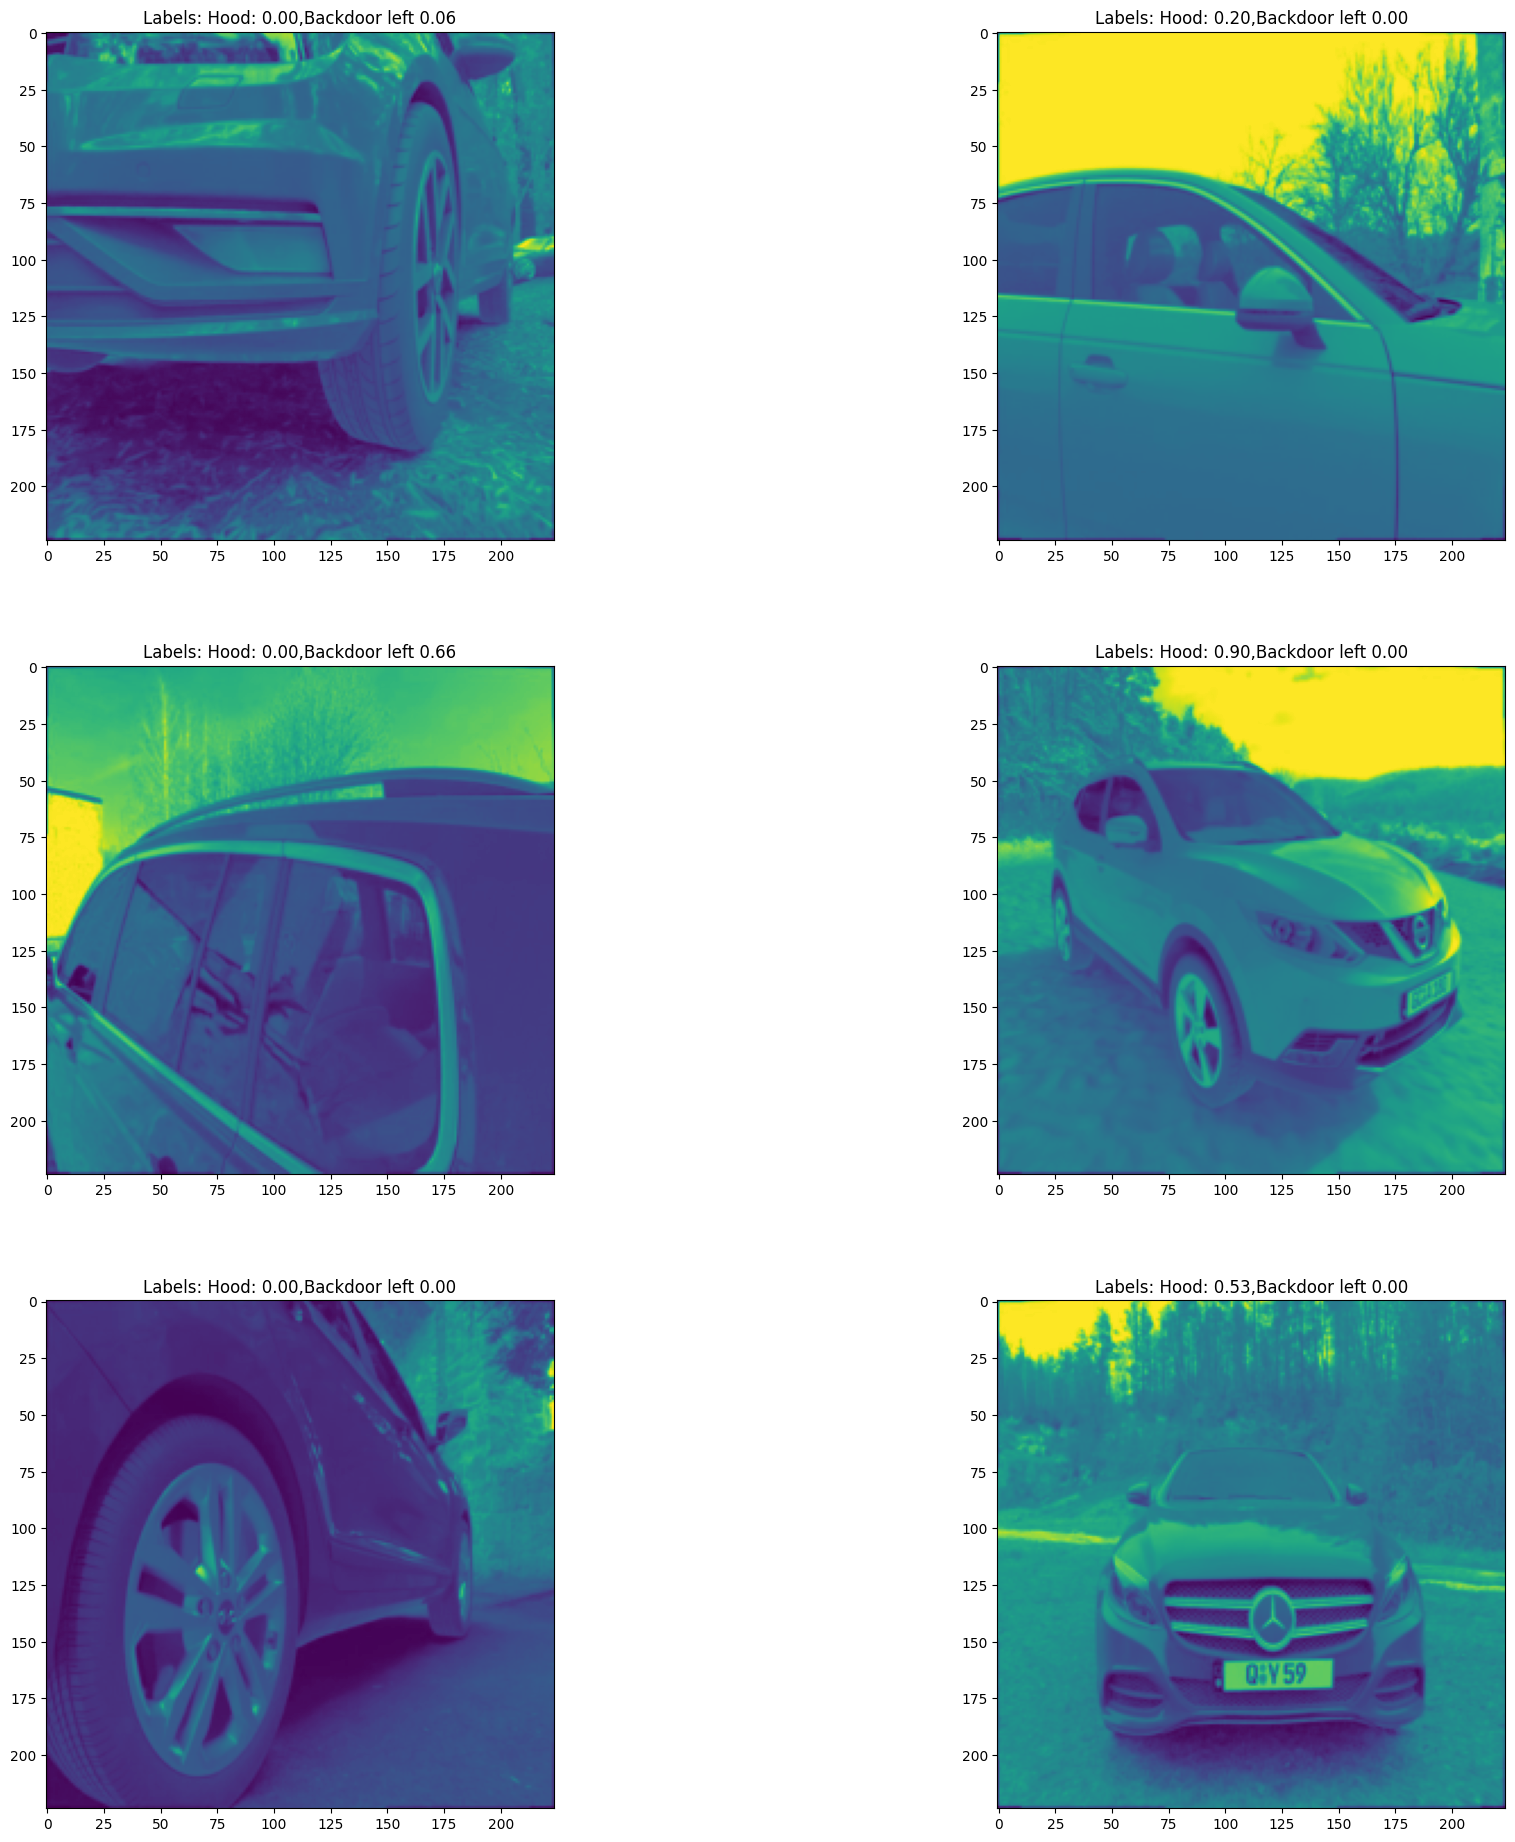

In [20]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    AdjustSharpness()
])

sharpness_adjusted_dataset = CustomDataset(csv_file=csv_file,
                                           root_dir=root_dir,
                                           transform=transform)

select_and_display_random_images(sharpness_adjusted_dataset, random_indices, num_images, is_tensor=True)